# Matrices

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

import numpy as np
import scipy.spatial as sp
import scipy.stats as ss
import tensorflow as tf

import similarities.loading as sl
import resources.dataset as rd
import resources.queries as rq
import methods.useful as mu

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
plt.rcParams["figure.figsize"] = (4,4)
mpl.rcParams['figure.dpi']= 150
mpl.rcParams['figure.titlesize']= 'xx-large'
mpl.rcParams['font.size']= 6
mpl.rcParams['image.cmap'] = 'jet'
cmap = cm.get_cmap('jet')
cmap.set_bad('w') # Print bads as white

sess = tf.Session() # tensorflow

### [Aminer Citation Network Datasets - v1 and v9](https://aminer.org/citation)



In [3]:
#data_path = "resources/aminer/v1"
data_path = "resources/aminer/v9"

### Select related documents or not

In [4]:
related_docs = True
use_svd_reconstruction = True

### Loading similarity matrices

Each matrix has similarity values between documents in a sample of scientific articles (Aminer), with one of the following measures.

 - word2vec. Mean of similarity of the bag of words in each document.
 - Jaccard. Using bag of words.

In [5]:
# Load sparse matrix with jaccard similarities.
matrix_tmp = sl.load_matrix_jaccard_sim(data_path, related_docs=related_docs)

n = matrix_tmp.shape[0]
matrix_jaccard = tf.constant(matrix_tmp, name='matrix_jaccard')
del matrix_tmp

# Load sparse matrix with word2vec similarities.
matrix_tmp = sl.load_matrix_word2vec_sim(data_path, related_docs=related_docs)
matrix_word2vec = tf.constant(matrix_tmp, name='matrix_word2vec')
del matrix_tmp

pltmask =  np.tri(n, k=-1) # Mask to plot upper triangular matrix.   

# Load document ids in the Same order than the matrices
indexdocs = rd.get_sample_ids(data_path)

print("\nMatrices.")
print(matrix_jaccard)
print(matrix_word2vec)

path resources/aminer/v9/measures-100-10-0-related-fullcontent-jaccard.bin


Loading measures from file ...
 - 500500 measures loaded from resources/aminer/v9/measures-100-10-0-related-fullcontent-jaccard.bin 
Sample size: 1000 documents
 - Content from resources/aminer/v9/sample-ids-100-10-0-related-fullcontent.bin


path resources/aminer/v9/measures-100-10-0-related-fullcontent-word2vec.bin


Loading measures from file ...
 - 500500 measures loaded from resources/aminer/v9/measures-100-10-0-related-fullcontent-word2vec.bin 
Sample size: 1000 documents
 - Content from resources/aminer/v9/sample-ids-100-10-0-related-fullcontent.bin



Matrices.
Tensor("matrix_jaccard:0", shape=(1000, 1000), dtype=float64)
Tensor("matrix_word2vec:0", shape=(1000, 1000), dtype=float64)


Sample size: 1000 documents
 - Content from resources/aminer/v9/sample-ids-100-10-0-related-fullcontent.bin


## SVD

In [6]:
if use_svd_reconstruction:
    svd_recons = mu.get_svd_reconstructions(sess, [matrix_jaccard, matrix_word2vec], n, nsv = 1)
    jaccard_approximation, jaccard_singular_values = next(svd_recons)
    word2vec_approximation, word2vec_singular_values = next(svd_recons)

Matrix reconstruction using 1 singular value(s) Tensor("Const:0", shape=(1000, 1000), dtype=float64) Tensor("Const_1:0", shape=(1000,), dtype=float64)
Matrix reconstruction using 1 singular value(s) Tensor("Const_2:0", shape=(1000, 1000), dtype=float64) Tensor("Const_3:0", shape=(1000,), dtype=float64)


In [7]:
if use_svd_reconstruction:
    X = jaccard_approximation
    Y = word2vec_approximation
else:
    X = matrix_jaccard
    Y = matrix_word2vec

A = tf.Variable(tf.zeros((n,n), dtype=tf.float64), dtype=tf.float64, name='A') 
# Means of jaccard similarities using the reconstructed matrix 
means, variances = tf.nn.moments(A, axes=[0])
# mean_means, variance_means = tf.nn.moments(means, axes=[0])
sess.run(tf.global_variables_initializer())

op = A.assign(X)
sess.run(op)
X_means = tf.convert_to_tensor(sess.run(means))
# Ordered indices by mean of similarities
X_indices = sess.run(means).argsort()[::-1]
X_variances = tf.convert_to_tensor(sess.run(variances))
# X_mean = tf.convert_to_tensor(sess.run(mean_means))

op = A.assign(Y)
sess.run(op)
Y_means = tf.convert_to_tensor(sess.run(means))
# Ordered indices by mean of similarities 
Y_indices = sess.run(means).argsort()[::-1]
Y_variances = tf.convert_to_tensor(sess.run(variances))

# Correlations 
EX = X_means
sigma_X = tf.sqrt(tf.reduce_sum((X-EX)**2, 1)/(n-1))

EY = Y_means
sigma_Y = tf.sqrt(tf.reduce_sum((Y-EY)**2, 1)/(n-1))

cov_XX = tf.reduce_sum((X-EX)**2, 1)/n
cov_YY = tf.reduce_sum((Y-EY)**2, 1)/n

# Covariance
cov_XY = tf.reduce_sum((X-EX)*(Y-EY), 1)/n
# Pearson 
ppc_XY = tf.divide(cov_XY, (sigma_X*sigma_Y))

# print(sess.run(tf.convert_to_tensor(np.array(list(map(ss.rankdata, sess.run(X))))) ))

# Spearman 
# rgX = tf.divide(tf.convert_to_tensor(sess.run(X).argsort(axis=1) + 1.0), n)
# rgY = tf.divide(tf.convert_to_tensor(sess.run(Y).argsort(axis=1) + 1.0), n)

# Ranks normalized with n 
# Note: uses scipy.stats.rankdata not TF because I didn't found an equivalent
rgX = tf.divide(tf.convert_to_tensor(np.array(list(map(ss.rankdata, sess.run(X))))) , n)
rgY = tf.divide(tf.convert_to_tensor(np.array(list(map(ss.rankdata, sess.run(Y))))) , n)

op = A.assign(rgX)
sess.run(op)
rgX_means = tf.convert_to_tensor(sess.run(means))
rgX_variances = tf.convert_to_tensor(sess.run(variances))

op = A.assign(rgY)
sess.run(op)
rgY_means = tf.convert_to_tensor(sess.run(means))
rgY_variances = tf.convert_to_tensor(sess.run(variances))

rgEX = rgX_means
sigma_rgX = tf.sqrt(tf.reduce_sum((rgX-rgEX)**2, 1)/(n-1) )

rgEY = rgY_means
sigma_rgY = tf.sqrt( tf.reduce_sum((rgY-rgEY)**2, 1)/(n-1) )

# Ranked Covariance
rcov_XY = tf.reduce_sum((rgX-rgEX)*(rgY-rgEY), 1)/n

# rs_XY = (-1 * tf.divide(6*tf.reduce_sum( ((ranked_X - ranked_Y)**2) , 1), n*(n**2 - 1)) ) + 1 
rs_XY = tf.divide(rcov_XY,(sigma_rgX*sigma_rgY))

# Kendall 
# print( np.array([tau for tau, _ in map(ss.kendalltau, sess.run(rgX),sess.run(rgY))])  ) 
kendalltau_rgXrgY = tf.convert_to_tensor(np.array([tau for tau, _ in map(ss.kendalltau, sess.run(rgX),sess.run(rgY))]))


## Plots 

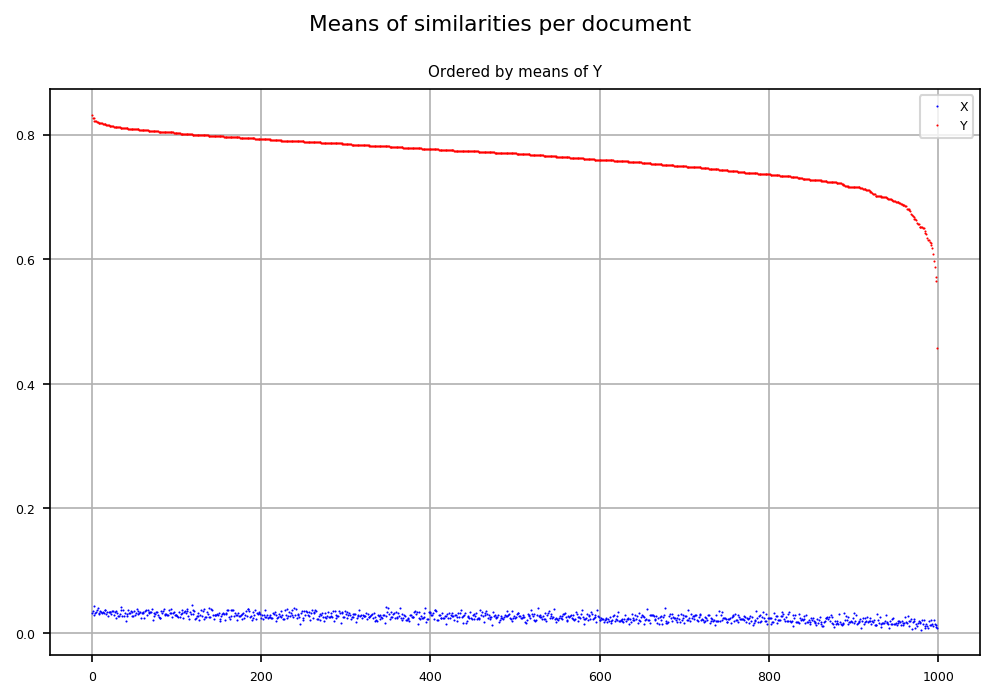

In [8]:
fig = plt.figure(figsize=(8,5))
fig.suptitle("Means of similarities per document")

X_means_ = sess.run(X_means)
Y_means_ = sess.run(Y_means)

ax_ = plt.subplot(1,1,1)
ax_.set_title("Ordered by means of Y")
#Plotting  of X similarities
ax_.plot(X_means_[Y_indices], 'b.', lw=0.1, mew=0.0, ms=2.0, label="X")
# ax_.plot([0,n], [X_means_, X_means_], lw=1.0, label="X mean")
#Plotting  of Y similarities
ax_.plot(Y_means_[Y_indices], 'r.', mew=0.0, ms=2.0, label="Y")

plt.grid(True)
plt.legend()
plt.show()

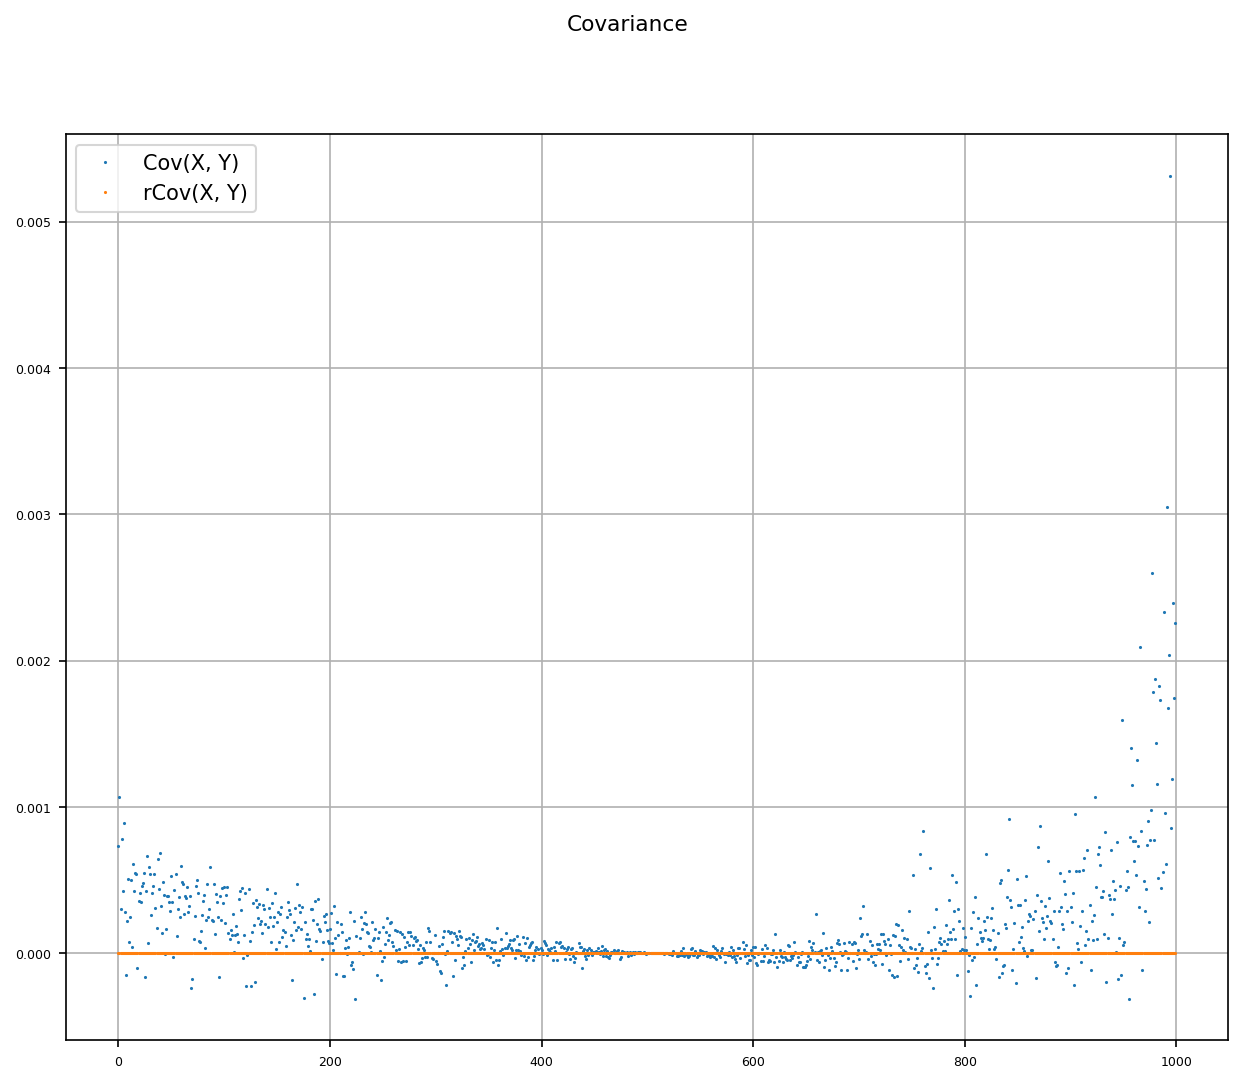

In [9]:
fig = plt.figure(figsize=(10,8))
fig.suptitle("Covariance")

cov_XY_ = sess.run(cov_XY)
rcov_XY_ = sess.run(rcov_XY)

ax_ = plt.subplot(1,1,1)
ax_.plot(cov_XY_[X_indices], '.', lw=0.5, mew=0.0, ms=3.0, label=r"Cov(X, Y)")
ax_.plot(rcov_XY_[X_indices], '.', lw=0.5, mew=0.0, ms=3.0, label=r"rCov(X, Y)")
plt.grid(True)
plt.legend(fontsize=10)
plt.show()

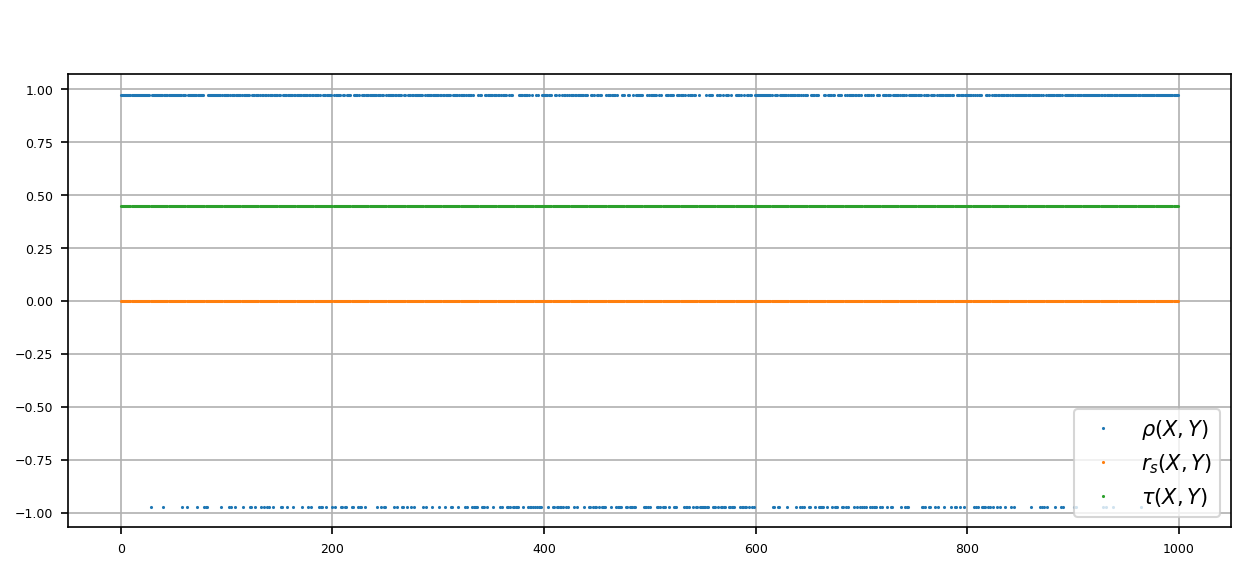

In [10]:
fig = plt.figure(figsize=(10,4))
fig.suptitle(" ")

ppc_XY_ = sess.run(ppc_XY)
rs_XY_ = sess.run(rs_XY)
kendalltau_rgXrgY_ = sess.run(kendalltau_rgXrgY)

ax_ = plt.subplot(1,1,1)
# ax_.plot(cov_XX[word2vec_indices], '.', lw=0.5, mew=0.0, ms=3.0, label="Cov(J, J)")
# ax_.plot(cov_YY[word2vec_indices], '.', lw=0.5, mew=0.0, ms=3.0, label="Cov(W, W)")
# ax_.plot(sess.run(cov_JW)[word2vec_indices], '.', lw=0.5, mew=0.0, ms=3.0, label=r"Cov(J, W)")

#ax_.plot(sess.run(sigma_X)[Y_indices], '*', lw=0.5, mew=0.0, ms=2.0, label="$\sigma_{x}$")
#ax_.plot(sess.run(sigma_Y)[Y_indices], '*', lw=0.5, mew=0.0, ms=2.0, label="$\sigma_{y}$")
#ax_.plot(sess.run(sigma_rgX)[Y_indices], '*', lw=0.5, mew=0.0, ms=2.0, label="$\sigma_{rgx}$")
#ax_.plot(sess.run(sigma_rgY)[Y_indices], '*', lw=0.5, mew=0.0, ms=2.0, label="$\sigma_{rgy}$")

ax_.plot(ppc_XY_[Y_indices], '.', lw=0.5, mew=0.0, ms=3.0, label=r"$\rho(X,Y)$")
ax_.plot(rs_XY_[Y_indices], '.', lw=0.5, mew=0.0, ms=3.0, label=r"$r_{s}(X,Y)$")
ax_.plot(kendalltau_rgXrgY_[Y_indices], '.', lw=0.5, mew=0.0, ms=3.0, label=r"$\tau(X,Y)$")

plt.grid(True)
plt.legend(fontsize=10)
plt.show()

In [11]:
# Ordering documents
indexdocs_ordered_word2vec = np.array(indexdocs)[Y_indices]
# Index 
ix_data = rq.cur_indexed_docs(data_path)

# Function to tokenize content
def bag_of_words_from_content(content):
    return " ".join(sorted(list(set([c.text for c in rd.analizer(content)]))))

In [12]:
n_documents = 1
cor = sess.run(ppc_XY)[Y_indices]

for i, idoc in enumerate(indexdocs_ordered_word2vec[:n_documents]):
    result = rq.find_indexdoc(ix_data, idoc)
    if cor[i] < 0.0:
        for r in result:
            print(i,"\t", r['content'])

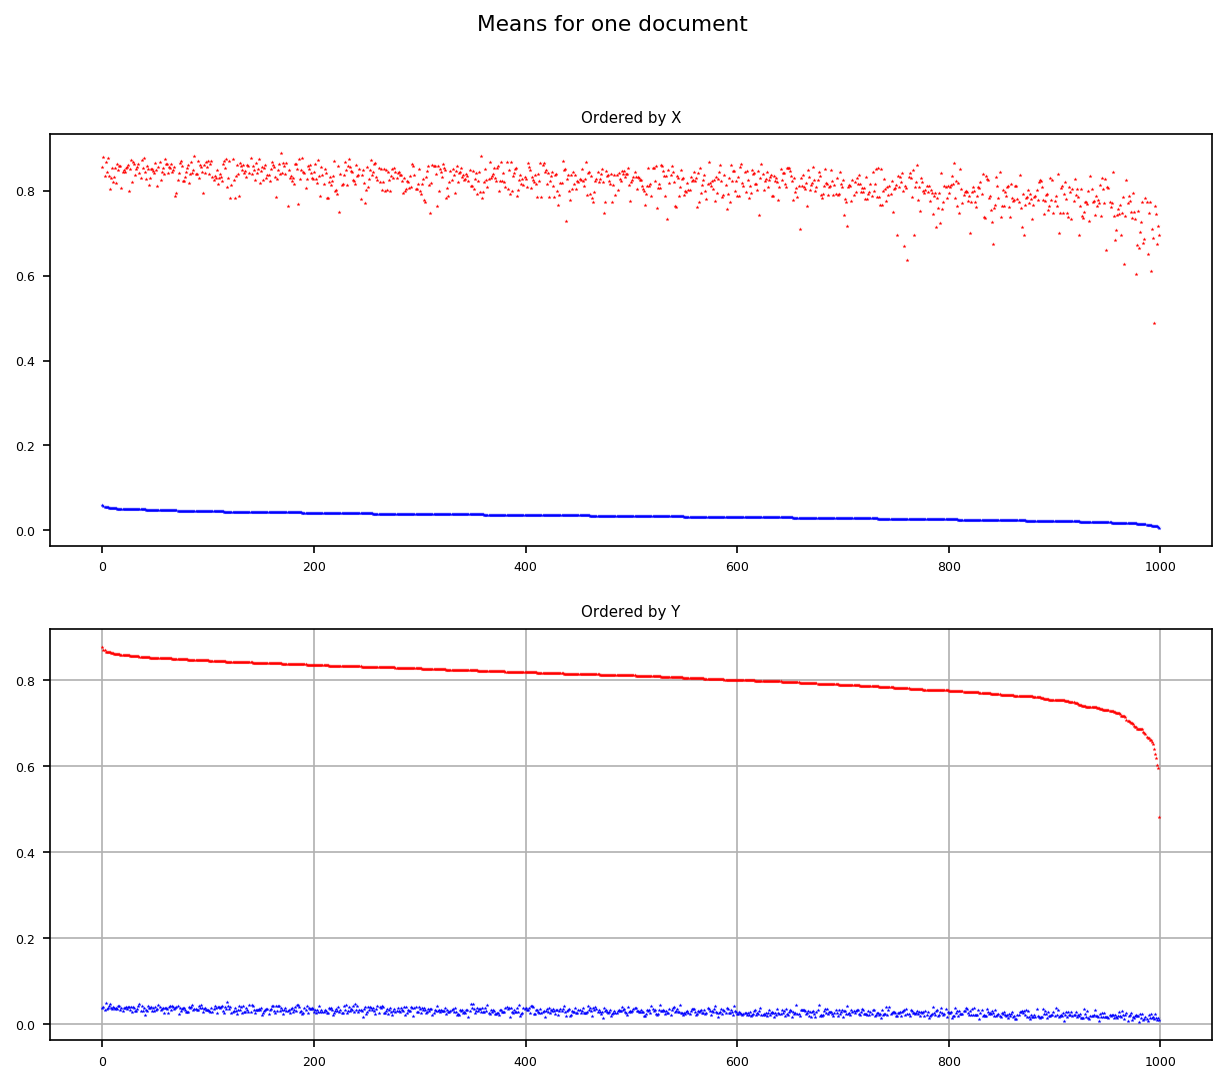

In [13]:
fig = plt.figure(figsize=(10, 8))
fig.suptitle("Means for one document")

Y_ = sess.run(Y)
X_ = sess.run(X)
document_offset = 100

ax_0 = plt.subplot(2, 1, 1)
ax_0.set_title("Ordered by X")
ax_0.plot(X_[:, X_indices][X_indices, :][:, document_offset:document_offset+1], "b*", lw=0.5, mew=0.0, ms=2.0)
ax_0.plot(Y_[:, X_indices][X_indices, :][:, document_offset:document_offset+1], "r*", lw=0.5, mew=0.0, ms=2.0)

ax_1 = plt.subplot(2, 1, 2)
ax_1.set_title("Ordered by Y")
ax_1.plot(X_[:, Y_indices][Y_indices, :][:, document_offset:document_offset+1], "b*", lw=0.5, mew=0.0, ms=2.0)
ax_1.plot(Y_[:, Y_indices][Y_indices, :][:, document_offset:document_offset+1], "r*", lw=0.5, mew=0.0, ms=2.0)

plt.grid(True)
# plt.legend(fontsize=10)
plt.show()